In [12]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [13]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Data Loading

In [25]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [26]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [27]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [28]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [29]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [30]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [31]:
patchesLabels.shape

NameError: name 'patchesLabels' is not defined

In [32]:
patchesData.shape

NameError: name 'patchesData' is not defined

In [33]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [34]:
K = X.shape[2]

In [35]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=3)

X.shape

(145, 145, 3)

In [36]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 3), (10249,))

In [32]:
145*145

21025

In [37]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 3), (7175, 25, 25, 3), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

In [38]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [36]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [41]:
num_classes = 16
input_shape = (25, 25, 3)

In [42]:
## input layer
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 23, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [44]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [45]:
# checkpoint
filepath = "mnist_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [46]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)


Epoch 1/100
3074/3074 [==============================] - 3s 899us/step - loss: 1.8387 - accuracy: 0.4122

Epoch 00001: accuracy improved from -inf to 0.41217, saving model to mnist_cnn.hdf5
Epoch 2/100
3074/3074 [==============================] - 3s 830us/step - loss: 1.0652 - accuracy: 0.6366

Epoch 00002: accuracy improved from 0.41217 to 0.63663, saving model to mnist_cnn.hdf5
Epoch 3/100
3074/3074 [==============================] - 3s 818us/step - loss: 0.7274 - accuracy: 0.7515

Epoch 00003: accuracy improved from 0.63663 to 0.75146, saving model to mnist_cnn.hdf5
Epoch 4/100
3074/3074 [==============================] - 2s 738us/step - loss: 0.5448 - accuracy: 0.8295

Epoch 00004: accuracy improved from 0.75146 to 0.82954, saving model to mnist_cnn.hdf5
Epoch 5/100
3074/3074 [==============================] - 2s 714us/step - loss: 0.4347 - accuracy: 0.8565

Epoch 00005: accuracy improved from 0.82954 to 0.85654, saving model to mnist_cnn.hdf5
Epoch 6/100
3074/3074 [==============

3074/3074 [==============================] - 3s 839us/step - loss: 0.0139 - accuracy: 0.9971

Epoch 00046: accuracy did not improve from 0.99707
Epoch 47/100
3074/3074 [==============================] - 2s 741us/step - loss: 0.0130 - accuracy: 0.9974

Epoch 00047: accuracy improved from 0.99707 to 0.99740, saving model to mnist_cnn.hdf5
Epoch 48/100
3074/3074 [==============================] - 3s 910us/step - loss: 0.0179 - accuracy: 0.9932

Epoch 00048: accuracy did not improve from 0.99740
Epoch 49/100
3074/3074 [==============================] - 3s 1ms/step - loss: 0.0180 - accuracy: 0.9935

Epoch 00049: accuracy did not improve from 0.99740
Epoch 50/100
3074/3074 [==============================] - 3s 1ms/step - loss: 0.0188 - accuracy: 0.9948

Epoch 00050: accuracy did not improve from 0.99740
Epoch 51/100
3074/3074 [==============================] - 3s 868us/step - loss: 0.0171 - accuracy: 0.9964

Epoch 00051: accuracy did not improve from 0.99740
Epoch 52/100
3074/3074 [=========

3074/3074 [==============================] - 2s 685us/step - loss: 0.0061 - accuracy: 0.9977

Epoch 00097: accuracy did not improve from 0.99935
Epoch 98/100
3074/3074 [==============================] - 2s 691us/step - loss: 0.0064 - accuracy: 0.9987

Epoch 00098: accuracy did not improve from 0.99935
Epoch 99/100
3074/3074 [==============================] - 2s 683us/step - loss: 0.0083 - accuracy: 0.9967

Epoch 00099: accuracy did not improve from 0.99935
Epoch 100/100
3074/3074 [==============================] - 2s 682us/step - loss: 0.1740 - accuracy: 0.9528

Epoch 00100: accuracy did not improve from 0.99935


L2 = 3
X,pca = applyPCA(X,numComponents=L2)
X, y = createImageCubes(X, y, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, L2, 1)
ytrain = np_utils.to_categorical(ytrain)
input_layer_resnet = Input((S, S, L2))
model1 = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer_resnet, input_shape=(S, S, L), pooling=None, classes=16)

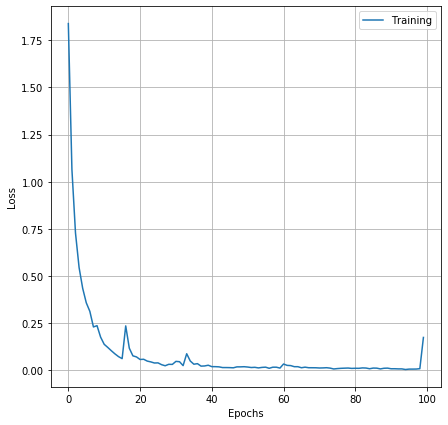

In [47]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

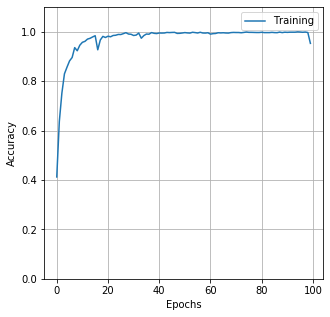

In [48]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [49]:
# load best weights
model.load_weights("mnist_cnn.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

In [51]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [52]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.98      1.00      0.99      1000
           2       1.00      0.99      0.99       581
           3       1.00      0.99      1.00       166
           4       1.00      0.99      1.00       338
           5       0.99      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      0.98      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy                           1.00      7175
   macro avg       1.00   

In [53]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [54]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [55]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

7175/7175 [==============================] - 1s 182us/step


In [56]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [57]:
# load the original image
X, y = loadData(dataset)

In [58]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [63]:
X,pca = applyPCA(X, numComponents=3)

In [64]:
X = padWithZeros(X, PATCH_SIZE//2)

In [65]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

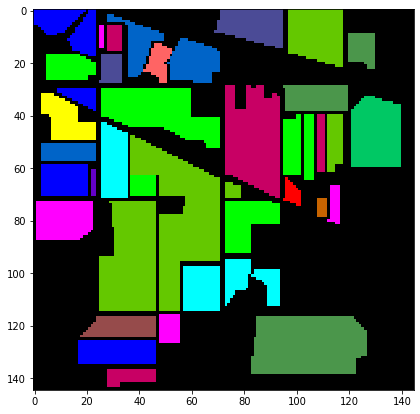

In [66]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

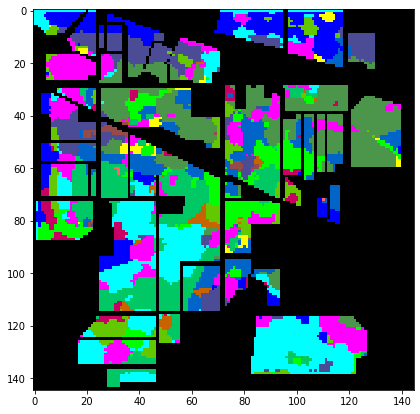

In [67]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [69]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [70]:
spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)